In [2]:
hillary_files = "output/hillary_data.csv"
bernie_files = "output/bernie_data.csv"
trump_files = "output/trump_data.csv"

In [3]:
import pyspark.sql as sql
import pyspark.sql.functions as fn
from pyspark.sql.types import *
from functools import reduce
from pyspark.sql.functions import col

def getValue(committee_id, result_list):
    result_column_list = result_list.where(col('CMTE_ID') == committee_id).collect()
    if(len(result_column_list) > 0):
        return result_column_list[0]['RESULT']
    else:
        return 0

def assignment_4():
    # File Paths
    campaign_contribution_file = "s3://rw-cs696-data/itcont.txt"
    header_file = "s3://rw-696-assignment-4/data/indiv_header_file.csv"
    output = "s3://rw-696-assignment-4/output/"

    hillary_for_america_id = 'C00575795'
    bernie_2016_id = 'C00577130'
    donald_trump_id = 'C00580100'

    campaign_ids = [hillary_for_america_id, bernie_2016_id, donald_trump_id]

    spark = sql.SparkSession.builder \
    .master("local[*]") \
    .appName("Election") \
    .getOrCreate()

    header_df = spark.read.option("header", "false").text(header_file)
    header = header_df.first()[0]
    schemaString = header.replace('\'','')
    newColumns = schemaString.split(',')

    campaign_contribution_df = spark.read.format("csv").option("header", "false").option("delimiter", "|").load(campaign_contribution_file)
    oldColumns = campaign_contribution_df.schema.names
    campaign_contribution_df = reduce(lambda campaign_contribution_df, idx: campaign_contribution_df.withColumnRenamed(oldColumns[idx], newColumns[idx]), range(len(oldColumns)), campaign_contribution_df)

    #	1.	How many donations did each campaign have?

    number_of_contributions = campaign_contribution_df.filter(col('CMTE_ID').isin(campaign_ids) & (col('TRANSACTION_AMT') > 0))\
    .groupBy("CMTE_ID")\
    .agg(fn.count("TRANSACTION_AMT").alias("RESULT"))

    print("Number of contributors for HILLARY FOR AMERICA is: %d" %getValue(hillary_for_america_id, number_of_contributions))
    print("Number of contributors for BERNIE 2016 is: %d" %getValue(bernie_2016_id, number_of_contributions))
    print("Number of contributors for DONALD J. TRUMP FOR PRESIDENT, INC. is: %d" %getValue(donald_trump_id, number_of_contributions))

    # 	2.	What was the total amount donated to each campaign?

    total_amount = campaign_contribution_df.filter(col('CMTE_ID').isin(campaign_ids))\
    .groupBy("CMTE_ID")\
    .agg(fn.sum("TRANSACTION_AMT").alias("RESULT"))

    hillary_total = getValue(hillary_for_america_id, total_amount);
    print("Total amount donated for HILLARY FOR AMERICA is: %.2f" % hillary_total)

    bernie_total = getValue(bernie_2016_id, total_amount)
    print("Total amount donated for BERNIE 2016 is: %.2f" %bernie_total)

    trump_total = getValue(donald_trump_id, total_amount)
    print("Total amount donated for DONALD J. TRUMP FOR PRESIDENT, INC. is: %.2f" % trump_total)

    # 	3.	What percentage of the each campaign's donations was done by small contributors?

    small_contri_total_amount = campaign_contribution_df.filter(col('CMTE_ID').isin(campaign_ids)\
    & (col('TRANSACTION_AMT') <= 200) & (col('TRANSACTION_AMT') > 0))\
    .groupBy("CMTE_ID")\
    .agg(fn.sum("TRANSACTION_AMT").alias("RESULT"))

    hillary_small_contri = getValue(hillary_for_america_id, small_contri_total_amount)
    bernie_small_contri = getValue(bernie_2016_id, small_contri_total_amount)
    trump_small_contri = getValue(donald_trump_id, small_contri_total_amount)

    print("Percentage of campaign's donations done by small contributors for HILLARY FOR AMERICA is: %.2f" \
          % (hillary_small_contri * 100/hillary_total))

    print("Percentage of campaign's donations done by small contributors for BERNIE 2016 is: %.2f" \
          % (bernie_small_contri * 100/bernie_total))

    print("Percentage of campaign's donations done by small contributors for DONALD J. TRUMP FOR PRESIDENT, INC. is: %.2f" \
          % (trump_small_contri * 100/trump_total))

    # 	4.	Produce a histogram of the donations for each campaign?

    campaign_contribution_df.select('TRANSACTION_AMT')\
    .filter((col('CMTE_ID') == hillary_for_america_id) & (col('TRANSACTION_AMT') > 0))\
    .coalesce(1).write.csv(output+'hillary_data.csv')

    campaign_contribution_df.select('TRANSACTION_AMT')\
    .coalesce(1).filter((col('CMTE_ID') == bernie_2016_id) & (col('TRANSACTION_AMT') > 0))\
    .coalesce(1).write.csv(output+'bernie_data.csv')

    campaign_contribution_df.select('TRANSACTION_AMT')\
    .filter((col('CMTE_ID') == donald_trump_id) & (col('TRANSACTION_AMT') > 0))\
    .coalesce(1).write.csv(output+'trump_data.csv')


Number of contributors for HILLARY FOR AMERICA is: 2515042
Number of contributors for BERNIE 2016 is: 1532046
Number of contributors for DONALD J. TRUMP FOR PRESIDENT, INC. is: 133115
Total amount donated for HILLARY FOR AMERICA is: 293602014.00
Total amount donated for BERNIE 2016 is: 84399789.00
Total amount donated for DONALD J. TRUMP FOR PRESIDENT, INC. is: 64624531.00
Percentage of campaign's donations done by small contributors for HILLARY FOR AMERICA is: 29.88
Percentage of campaign's donations done by small contributors for BERNIE 2016 is: 59.33
Percentage of campaign's donations done by small contributors for DONALD J. TRUMP FOR PRESIDENT, INC. is: 7.98

Asumptions: 

The data contains some negative transactions. The transactions don't have a unique ID to represent transactions made per user.

I have considered only positive transactions while calculating total number of contributions per campaign.
Hillary clinton's campaign has more contributors. Second highest contributors are for Bernie's campaign.

To calculate the total amount contributed to each campaign I have take positive as well as negative contributions into consideration as the negative contributions affect the total amount.
Hillary campaign has raised the highest funds. It might be because the candidate was in the race till the end of the elections. Although Donald trump's campaign has raised less funds than Bernie's campaign, even though Bernie Sanders was out of the race after primaries.

The Bernie campaign has the highest percentage of amount given by small doners. Whereas The Trump campaign has the lowest.



4. Produce a histogram of the donations for each campaign?

In [4]:

import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt

from os import listdir
from os.path import isfile, join

def get_data_from_files(file_path):
    files=os.listdir(file_path)
    for idx,file in enumerate(files):
        if file.endswith(".csv"):
            data = spark.read.format("csv").option("header", "false").load(os.path.join(file_path, file))
            complete_data = data
            break
    return complete_data.withColumnRenamed(complete_data.schema.names[0], 'TRANSACTION_AMT').collect();

hillary_data = get_data_from_files(hillary_files)
bernie_data = get_data_from_files(bernie_files)
trump_data = get_data_from_files(trump_files)


Text(0, 0.5, 'Frequency')

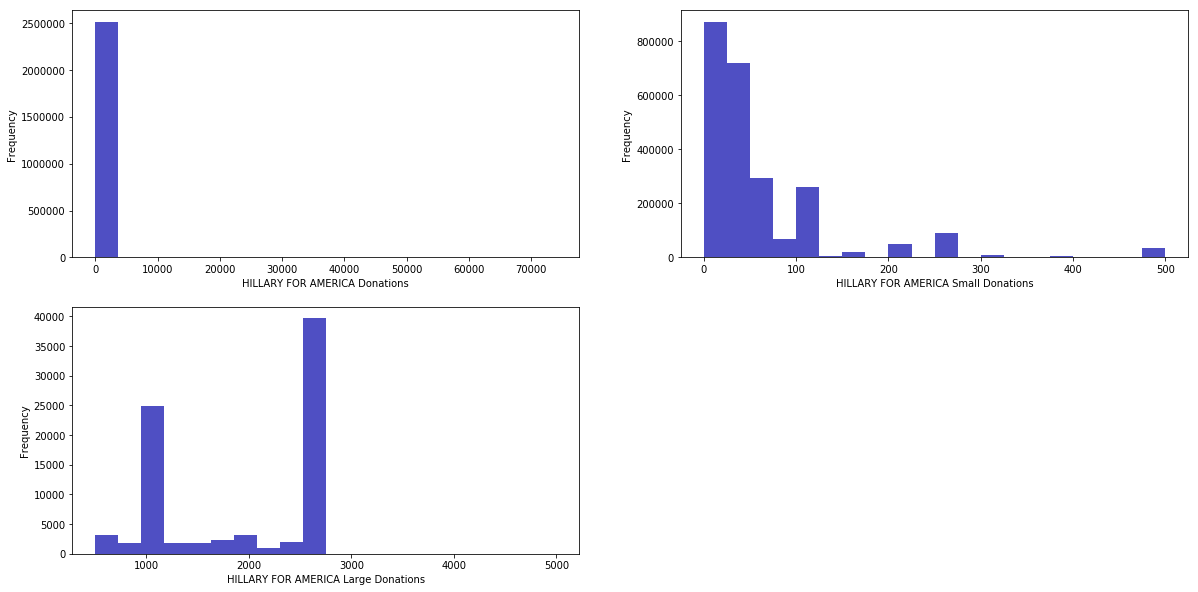

In [10]:
figure1 = plt.figure(figsize=(20,10))

axes1 = figure1.add_subplot(2, 2, 1)
plt.hist([int(row.TRANSACTION_AMT) for row in hillary_data], bins=20, color='#0504aa')
plt.xlabel('HILLARY FOR AMERICA Donations')
plt.ylabel('Frequency')

axes2 = figure1.add_subplot(2, 2, 2)
plt.hist([int(row.TRANSACTION_AMT) for row in hillary_data], bins=20, color='#0504aa', range = [0, 500])
plt.xlabel('HILLARY FOR AMERICA Small Donations')
plt.ylabel('Frequency')

axes3 = figure1.add_subplot(2, 2, 3)
plt.hist([int(row.TRANSACTION_AMT) for row in hillary_data], bins=20, color='#0504aa', range = [501, 5000])
plt.xlabel('HILLARY FOR AMERICA Large Donations')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

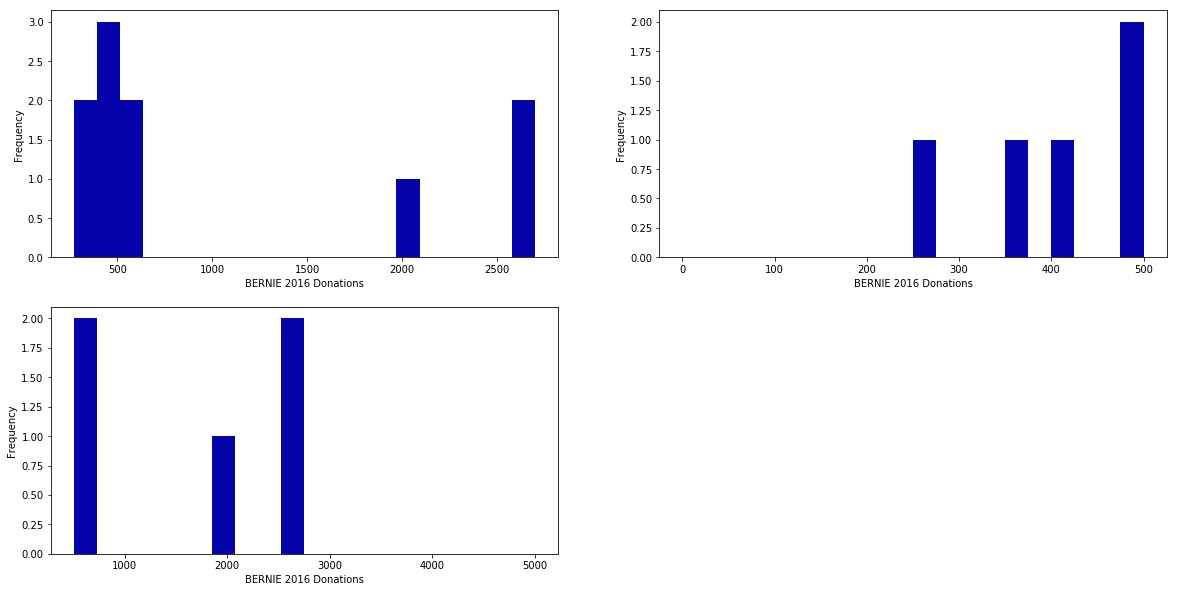

In [30]:
figure2 = plt.figure(figsize=(20,10))

axes1 = figure2.add_subplot(2, 2, 1)
plt.hist([int(row.TRANSACTION_AMT) for row in bernie_data], bins=20, color='#0504aa')
plt.xlabel('BERNIE 2016 Donations')
plt.ylabel('Frequency')

axes2 = figure2.add_subplot(2, 2, 2)
plt.hist([int(row.TRANSACTION_AMT) for row in bernie_data], bins=20, color='#0504aa', range = [0, 500])
plt.xlabel('BERNIE 2016 Small Donations')
plt.ylabel('Frequency')

axes3 = figure2.add_subplot(2, 2, 3)
plt.hist([int(row.TRANSACTION_AMT) for row in bernie_data], bins=20, color='#0504aa', range = [501, 5000])
plt.xlabel('BERNIE 2016 Large Donations')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

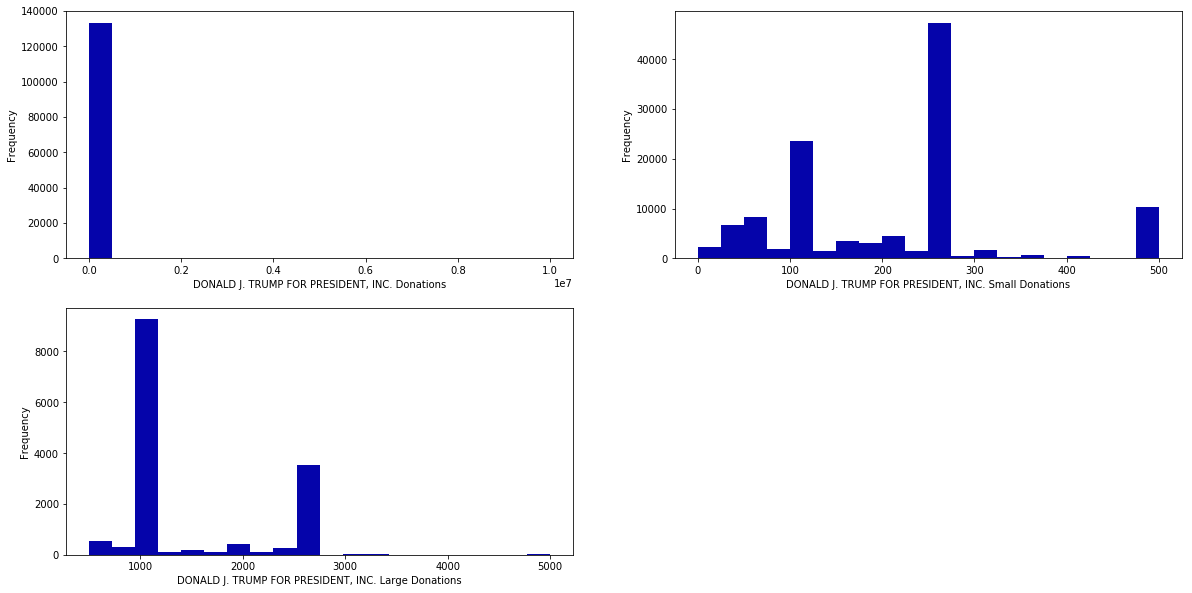

In [8]:
figure3 = plt.figure(figsize=(20,10))

axes3 = figure3.add_subplot(2, 2, 1)
plt.hist([int(row.TRANSACTION_AMT) for row in trump_data], bins=20, color='#0504aa')
plt.xlabel('DONALD J. TRUMP FOR PRESIDENT, INC. Donations')
plt.ylabel('Frequency')

axes3 = figure3.add_subplot(2, 2, 2)
plt.hist([int(row.TRANSACTION_AMT) for row in trump_data], bins=20, color='#0504aa', range = [0, 500])
plt.xlabel('DONALD J. TRUMP FOR PRESIDENT, INC. Small Donations')
plt.ylabel('Frequency')

axes3 = figure3.add_subplot(2, 2, 3)
plt.hist([int(row.TRANSACTION_AMT) for row in trump_data], bins=20, color='#0504aa', range = [501, 5000])
plt.xlabel('DONALD J. TRUMP FOR PRESIDENT, INC. Large Donations')
plt.ylabel('Frequency')

                                            AWS CLI export command

aws emr create-cluster --applications Name=Ganglia Name=Spark Name=Zeppelin --ebs-root-volume-size 10 --ec2-attributes '{"InstanceProfile":"EMR_EC2_DefaultRole","SubnetId":"subnet-dc1a70a6","EmrManagedSlaveSecurityGroup":"sg-07d3938b94bc3dbf2","EmrManagedMasterSecurityGroup":"sg-0db8f09a05f5f4c6f"}' --service-role EMR_DefaultRole --enable-debugging --release-label emr-5.23.0 --log-uri 's3n://aws-logs-029750695188-us-east-2/elasticmapreduce/' --steps '[{"Args":["spark-submit","--deploy-mode","client","s3://rw-696-assignment-4/Assignment-4.py"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"},{"Args":["spark-submit","--deploy-mode","client","s3://rw-696-assignment-4/Assignment-4.py"],"Type":"CUSTOM_JAR","ActionOnFailure":"CONTINUE","Jar":"command-runner.jar","Properties":"","Name":"Spark application"}]' --name 'My cluster CS-696' --instance-groups '[{"InstanceCount":1,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"MASTER","InstanceType":"m4.xlarge","Name":"Master Instance Group"},{"InstanceCount":2,"EbsConfiguration":{"EbsBlockDeviceConfigs":[{"VolumeSpecification":{"SizeInGB":32,"VolumeType":"gp2"},"VolumesPerInstance":2}]},"InstanceGroupType":"CORE","InstanceType":"m4.xlarge","Name":"Core Instance Group"}]' --scale-down-behavior TERMINATE_AT_TASK_COMPLETION --region us-east-2